# 1.Load the Data

In [ ]:
#impoart libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import re
import string
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from itertools import product
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#load the data
df = pd.read_csv('Combined Data.csv')

In [ ]:
#Drop NULLs
df.dropna(inplace = True)

In [ ]:
df.shape

(52681, 3)

In [ ]:
df = df.iloc[:,1:]

In [ ]:
df.describe().T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


In [ ]:
#As we are going to do multi-class classifications here, simple label encode the df
label_encoder = LabelEncoder()
df['encoded_status'] = label_encoder.fit_transform(df['status'])


In [ ]:
#shuffle the data
random.seed(1234)
df = shuffle(df)
df

,statement,status,encoded_status
7914,I am done with my life. I just want to end my ...,Depression,2
28930,She's sworn at me at times. **tl;dr**: Girlf...,Stress,5
12044,I am coming out of a really bad depressive epi...,Depression,2
20216,i was doing very well for some time now. proba...,Depression,2
27008,90mg of xanax and a 1.5 l of wine? I do not wa...,Suicidal,6
...,...,...,...
29186,"Short-end is, my brain is using physical disor...",Stress,5
4598,sik like the taste of camtok «,Normal,3
43657,tried with smsjunction com but got odbc driver...,Normal,3
11985,Just lost my job today. It has not been a grea...,Depression,2


After bacis cleaning dropping the NULLs, the data contains 52681 records with 2 columns, statement \(text\) and status \(status\) .
There are 7 unique status, we use a simple label encoding to represent this

# 3.Modeling

## 3.1 Classical ML Model

### 3.1.0 Pre-processing for classical ML Models


In [ ]:
#make a copy of data especially for classical ML Models
df1 = df.copy()

In [ ]:
# Step 1: Clean the Text
# Purpose: Removes noise (e.g., special characters, extra spaces) that doesn't contribute to understanding the text's meaning.
def clean_text(text):
    """Cleans input text from social media for NLP models.

    Args:
        text (str): The input text.

    Returns:
        str: The cleaned text.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df1['statement'] = df1['statement'].apply(clean_text)

In [ ]:
#Step 2: stopwords removal
#Stop words (e.g., "and", "is", "the") do not carry much meaning and can be removed to reduce noise.
stop_words = set(stopwords.words('english'))
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [ ]:
#Step 3：lemmatize
# Reduces words to their base or root forms, ensuring that variations of the same word are treated equally (e.g., "running", "runs", "ran" → "run").
lemmatizer = WordNetLemmatizer()
df1['statement'] = df1['statement'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [ ]:
#Step 4: Train-Test Split
#Random sample, use 20% data for test, 80% data for train
X1 = df['statement']
y1 = df['encoded_status']

# Initial train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X1.tolist(), y1.tolist(), test_size=0.2, random_state=42
)

# Further split training data into training and validation sets
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train_1, y_train_1, test_size=0.25, random_state=42  # for validation: 0.25 * 0.8 = 0.2 of original data
)


In [ ]:
# Step 5: TF-IDF Vectorization
#Converts raw text into numerical features for input to ML models
tfidf = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)  # Fit on training data
X_test_tfidf_1 = tfidf.transform(X_test_1)       # Transform test data

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

# Fit TF-IDF on training data
tfidf.fit(X_train_1)

# Transform train, validation, and test sets
X_train_1= tfidf.transform(X_train_1)
X_val_1 = tfidf.transform(X_val_1)
X_test_1 = tfidf.transform(X_test_1)

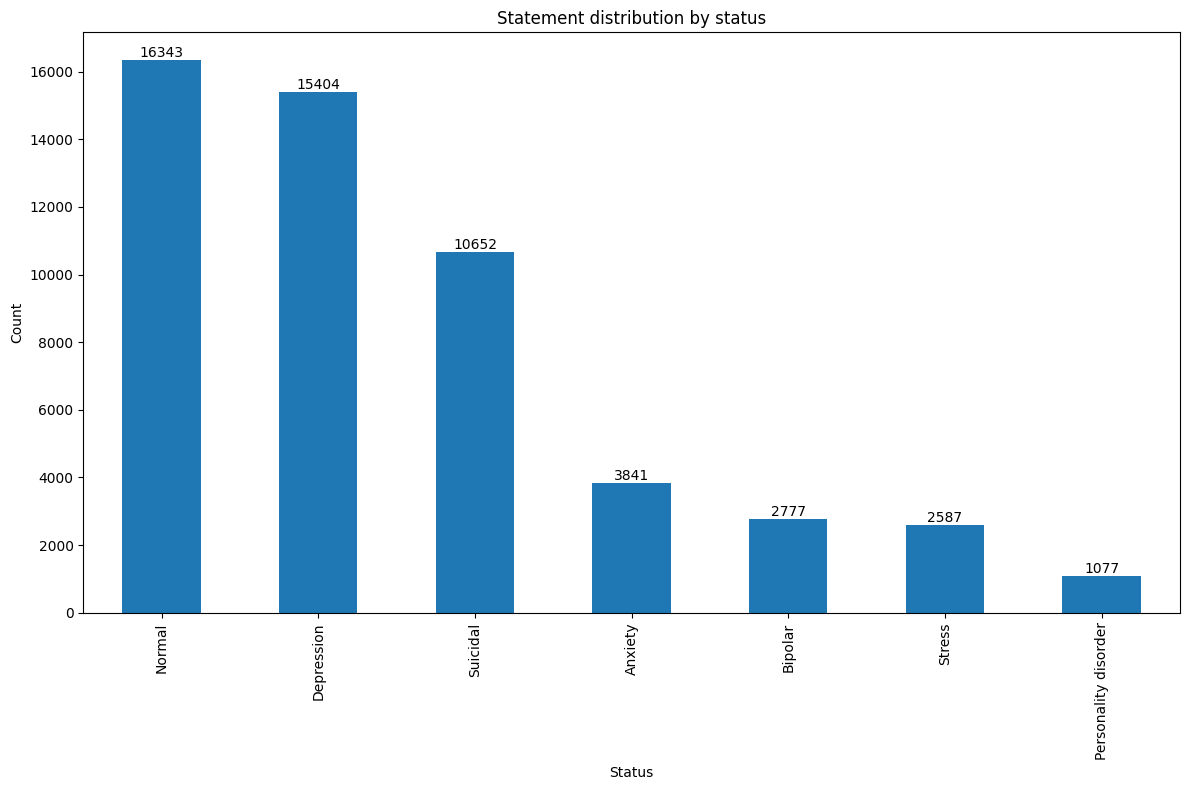

In [ ]:
#Step 6: Handeling class-imbalance
# As shown by below plot, there are class-imbalance issues
# Therefore, we would need to balance the class distribution in the training set, we will do so by using a balanced class weights in training
plt.figure(figsize=(12,8))
status_counts = df1['status'].value_counts()
ax = status_counts.plot(kind='bar')
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
#SMOTE technique used to resample the class
# smote = SMOTE(random_state=42)
# X_train_resampled_1, y_train_resampled_1 = smote.fit_resample(X_train_tfidf_1, y_train_1)

Notes here:

* TF-IDF Before SMOTE:

Apply TF-IDF vectorization before applying SMOTE because SMOTE works on numerical data, not raw text.

*  SMOTE Only on the Training Set:

SMOTE is applied to the training set after vectorization. This avoids leaking synthetic samples into the test set.
*   .
Test Set Remains Unaltered:

The test set is only transformed using the TF-IDF vocabulary and IDF weights learned from the training set.

### 3.1.0 SVM

In [ ]:
random.seed(1234)

# Reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength
    'kernel': ['linear', 'rbf'],  # Commonly used kernels
    'class_weight': ['balanced',None], # Handle class imbalance
    'gamma': ['scale'],           # Default kernel coefficient
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, kernel, class_weight, gamma in product(param_grid['C'], param_grid['kernel'], param_grid['class_weight'], param_grid['gamma']):
    try:
        # Create the SVM model with current parameters
        model = SVC(C=C, kernel=kernel, class_weight=class_weight, gamma=gamma, random_state=42)

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {'C': C, 'kernel': kernel, 'class_weight': class_weight, 'gamma': gamma}
    except Exception as e:
        print(f"Skipping combination C={C}, kernel={kernel}, class_weight={class_weight}, gamma={gamma} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, kernel=linear, class_weight=balanced, gamma=scale: 0.7142


In [ ]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = best_model.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred, digits=4))
f1_score(y_test_1, y_test_pred, average = 'weighted')


Test Performance:
              precision    recall  f1-score   support

           0     0.7935    0.8202    0.8066       773
           1     0.8877    0.7145    0.7917       564
           2     0.7379    0.6354    0.6828      3061
           3     0.8394    0.9414    0.8875      3243
           4     0.9179    0.5748    0.7069       214
           5     0.6723    0.5507    0.6055       503
           6     0.6604    0.7471    0.7011      2179

    accuracy                         0.7652     10537
   macro avg     0.7870    0.7120    0.7403     10537
weighted avg     0.7657    0.7652    0.7613     10537



0.7613063809985965

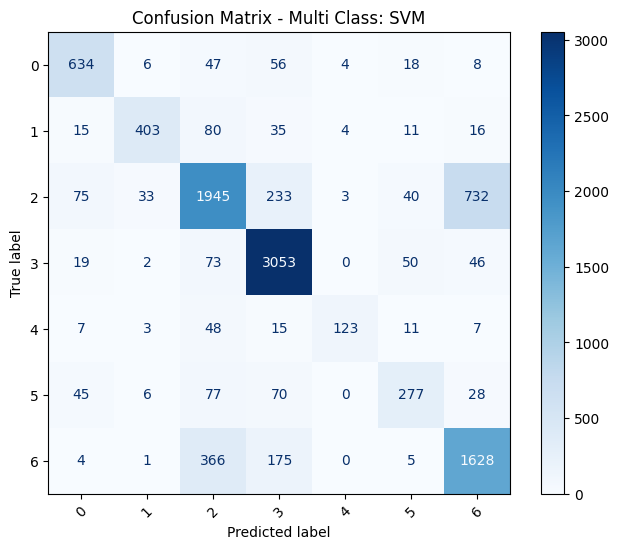

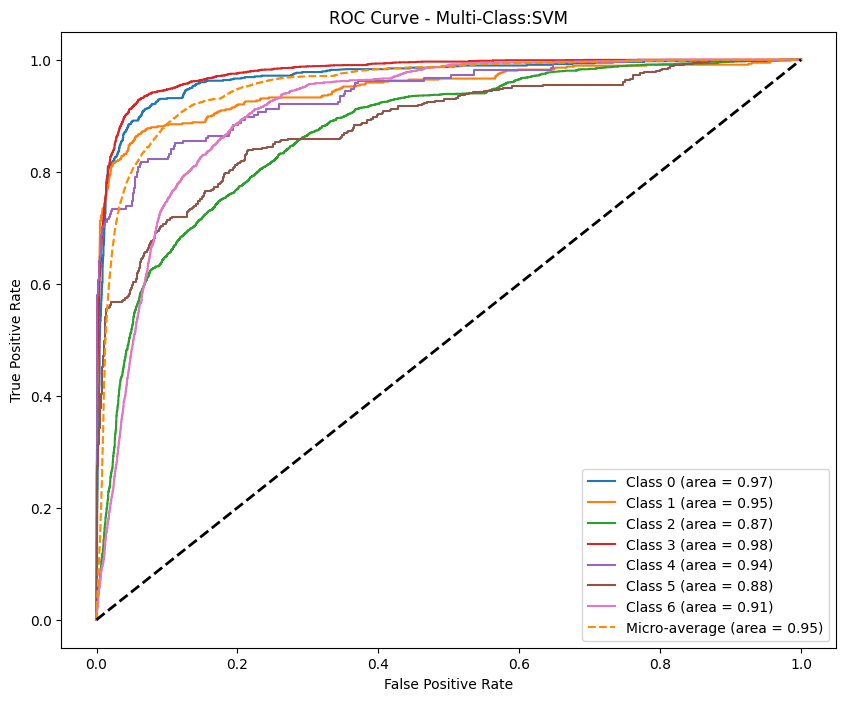

In [ ]:
#Plot confusion matrix and ROV curves
# Compute confusion matrix
cm = confusion_matrix(y_test_1, y_test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multi Class: SVM")
plt.show()

n_classes = len(set(y_test_1))  # Number of classes
y_test_binarized = label_binarize(y_test_1, classes=list(range(n_classes)))

# Predict probabilities for each class
y_test_prob = best_model.decision_function(X_test_1)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Individual ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (area = {roc_auc['micro']:.2f})", linestyle='--', color='darkorange')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curve - Multi-Class:SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 3.1.1 Logistic Regression

In [ ]:
random.seed(1234)

# Reduced parameter grid for logistic regression
param_grid = {
    'C': [0.1, 1, 10],                # Regularization strength
    'solver': ['lbfgs', 'saga'],      # Optimization solvers
    'penalty': ['l2'],                # L2 regularization
    'multi_class': ['multinomial'],   # Multiclass strategy: using multinomial for multi-class classification
    'class_weight': ['balanced', None],     # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for C, solver, penalty, multi_class, class_weight in product(
        param_grid['C'], param_grid['solver'], param_grid['penalty'], param_grid['multi_class'], param_grid['class_weight']):
    try:
        # Create the Logistic Regression model with current parameters
        model = LogisticRegression(
            C=C,
            solver=solver,
            penalty=penalty,
            multi_class=multi_class,
            class_weight=class_weight,
            max_iter=1000,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'C': C,
                'solver': solver,
                'penalty': penalty,
                'multi_class': multi_class,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination C={C}, solver={solver}, penalty={penalty}, multi_class={multi_class}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)


Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7074
Validation F1-Score for C=0.1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.6530
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7081
Validation F1-Score for C=0.1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.6529
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7504
Validation F1-Score for C=1, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=None: 0.7464
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7358
Validation F1-Score for C=1, solver=saga, penalty=l2, multi_class=multinomial, class_weight=None: 0.7454
Validation F1-Score for C=10, solver=lbfgs, penalty=l2, multi_class=multinomial, class_weight=balanced: 0.7548
Validation F1-Score f

In [ ]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = best_model.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred, digits=4))
f1_score(y_test_1, y_test_pred, average = 'weighted')


Test Performance:
              precision    recall  f1-score   support

           0     0.7709    0.7878    0.7793       773
           1     0.7788    0.7553    0.7669       564
           2     0.7296    0.6276    0.6747      3061
           3     0.8821    0.9140    0.8978      3243
           4     0.6189    0.7056    0.6594       214
           5     0.5144    0.6044    0.5558       503
           6     0.6463    0.7035    0.6737      2179

    accuracy                         0.7505     10537
   macro avg     0.7058    0.7283    0.7154     10537
weighted avg     0.7525    0.7505    0.7498     10537



0.7497783348632833

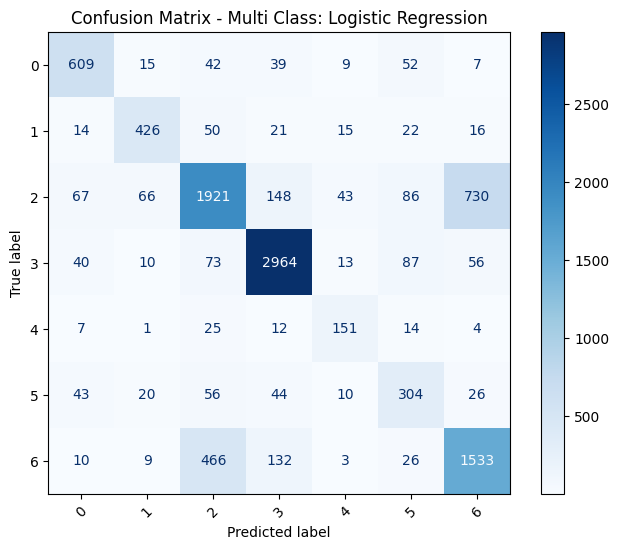

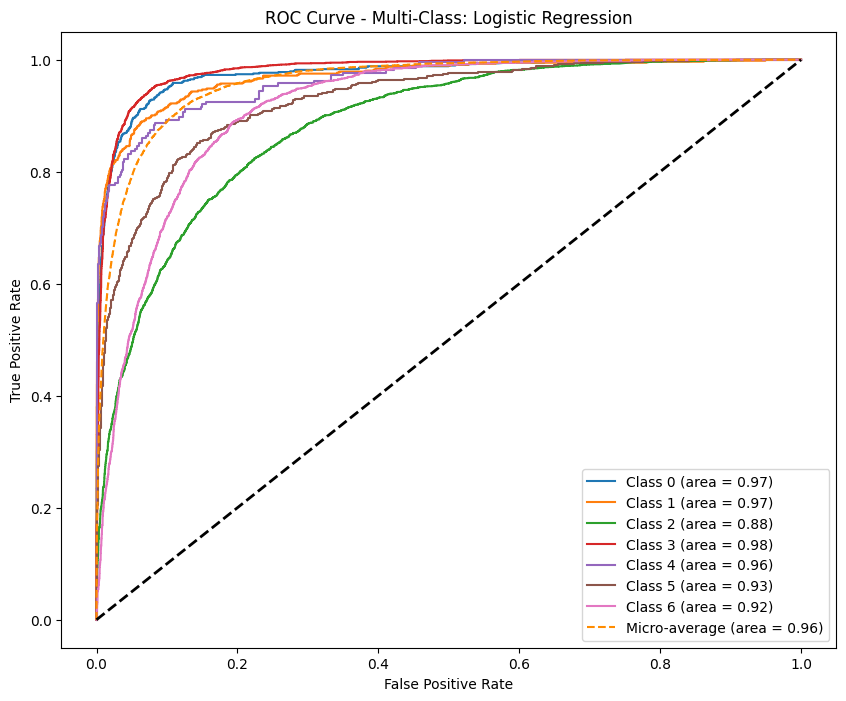

In [ ]:
#Plot confusion matrix and ROV curves
# Compute confusion matrix
cm = confusion_matrix(y_test_1, y_test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multi Class: Logistic Regression")
plt.show()

n_classes = len(set(y_test_1))  # Number of classes
y_test_binarized = label_binarize(y_test_1, classes=list(range(n_classes)))

# Predict probabilities for each class
y_test_prob = best_model.predict_proba(X_test_1)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Individual ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (area = {roc_auc['micro']:.2f})", linestyle='--', color='darkorange')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curve - Multi-Class: Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### 3.1.2 Random Forest

In [ ]:
random.seed(1234)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20],          # Depth of the tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'class_weight': ['balanced', None],   # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight in product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['min_samples_split'],
        param_grid['min_samples_leaf'],
        param_grid['class_weight']):
    try:
        # Create the Random Forest model with current parameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)



Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=balanced: 0.7044
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None: 0.6911
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=balanced: 0.7432
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, class_weight=None: 0.6814
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=balanced: 0.7329
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4, class_weight=None: 0.6529
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=balanced: 0.7249
Validation F1-Score for n_estimators=50, max_depth=None, min_samples_split=5, min_samples_leaf=1, class_weight=None:

In [ ]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = best_model.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred, digits=4))
f1_score(y_test_1, y_test_pred, average = 'weighted')


Test Performance:
              precision    recall  f1-score   support

           0     0.7557    0.8163    0.7848       773
           1     0.8067    0.7252    0.7638       564
           2     0.7077    0.6606    0.6833      3061
           3     0.8615    0.9149    0.8874      3243
           4     0.9828    0.5327    0.6909       214
           5     0.6114    0.4692    0.5309       503
           6     0.6392    0.7017    0.6690      2179

    accuracy                         0.7505     10537
   macro avg     0.7664    0.6886    0.7157     10537
weighted avg     0.7507    0.7505    0.7478     10537



0.7478049803085999

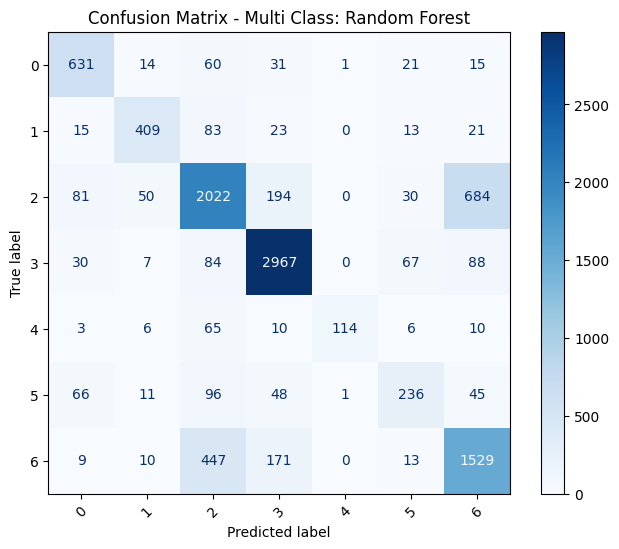

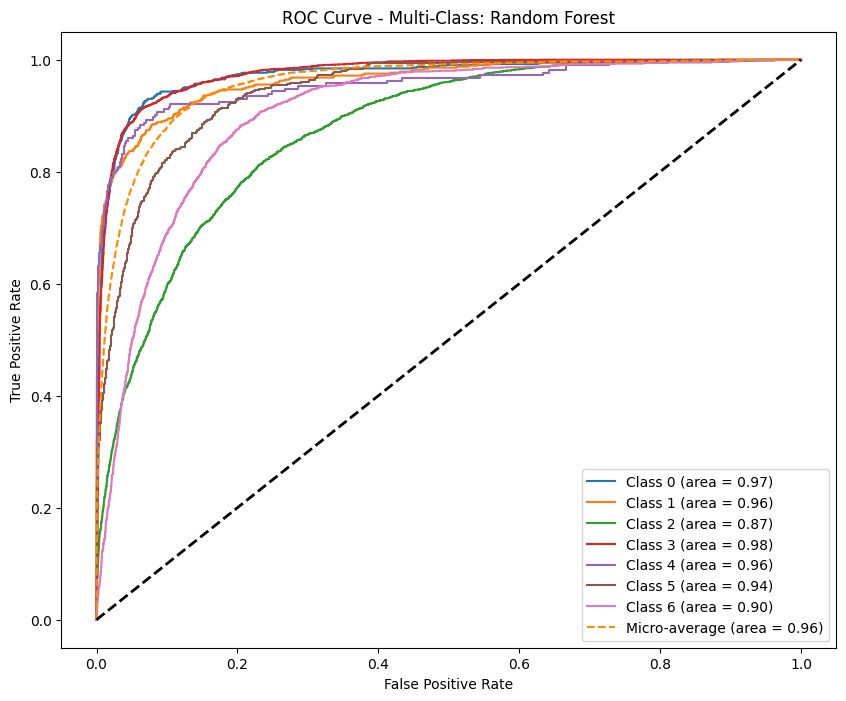

In [ ]:
#Plot confusion matrix and ROV curves
# Compute confusion matrix
cm = confusion_matrix(y_test_1, y_test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multi Class: Random Forest")
plt.show()

n_classes = len(set(y_test_1))  # Number of classes
y_test_binarized = label_binarize(y_test_1, classes=list(range(n_classes)))

# Predict probabilities for each class
y_test_prob = best_model.predict_proba(X_test_1)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Individual ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (area = {roc_auc['micro']:.2f})", linestyle='--', color='darkorange')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curve - Multi-Class: Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 3.1.3 LGBM

In [ ]:
random.seed(1234)

# Parameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 200],          # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'num_leaves': [31, 63],              # Maximum number of leaves in a tree
    'max_depth': [None, 10],             # Maximum tree depth
    'class_weight': ['balanced', None],      # Handle class imbalance
}

# Initialize variables to track the best model and parameters
best_f1 = 0
best_model = None
best_params = None

# Start timer
start_time = time.time()

# Iterate through reduced parameter grid
for n_estimators, learning_rate, num_leaves, max_depth, class_weight in product(
        param_grid['n_estimators'],
        param_grid['learning_rate'],
        param_grid['num_leaves'],
        param_grid['max_depth'],
        param_grid['class_weight']):
    try:
        # Create the LightGBM model with current parameters
        model = LGBMClassifier(
            objective='multiclass',                # Multi-class objective
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42
        )

        # Train the model
        model.fit(X_train_1, y_train_1)

        # Validate the model on validation set
        y_val_pred = model.predict(X_val_1)
        f1 = f1_score(y_val_1, y_val_pred, average='weighted')  # Multi-class F1-score
        print(f"Validation F1-Score for n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight}: {f1:.4f}")

        # Update the best model if current one is better
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_params = {
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'num_leaves': num_leaves,
                'max_depth': max_depth,
                'class_weight': class_weight
            }
    except Exception as e:
        print(f"Skipping combination n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}, max_depth={max_depth}, class_weight={class_weight} due to error: {e}")

# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

# Print the best parameters and F1 score on validation set
print("\nBest Hyperparameters:", best_params)
print("Best Validation F1-Score:", best_f1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246398
[LightGBM] [Info] Number of data points in the train set: 31608, number of used features: 5151
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Validation F1-Score for n_estimators=100, learning_rate=0.01, num_leaves=31, max_depth=None, class_weight=balanced: 0.6908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 246398
[LightGB

In [ ]:
# Evaluate the Model on test set, with best parameters found
y_test_pred = best_model.predict(X_test_1)
print("\nTest Performance:")
print(classification_report(y_test_1, y_test_pred, digits=4))
f1_score(y_test_1, y_test_pred, average = 'weighted')


Test Performance:
              precision    recall  f1-score   support

           0     0.8250    0.8111    0.8180       773
           1     0.8859    0.7571    0.8164       564
           2     0.7156    0.7004    0.7079      3061
           3     0.8971    0.9272    0.9119      3243
           4     0.8808    0.6215    0.7288       214
           5     0.6275    0.5726    0.5988       503
           6     0.6602    0.7081    0.6833      2179

    accuracy                         0.7753     10537
   macro avg     0.7846    0.7283    0.7522     10537
weighted avg     0.7763    0.7753    0.7747     10537



0.7747219145381448

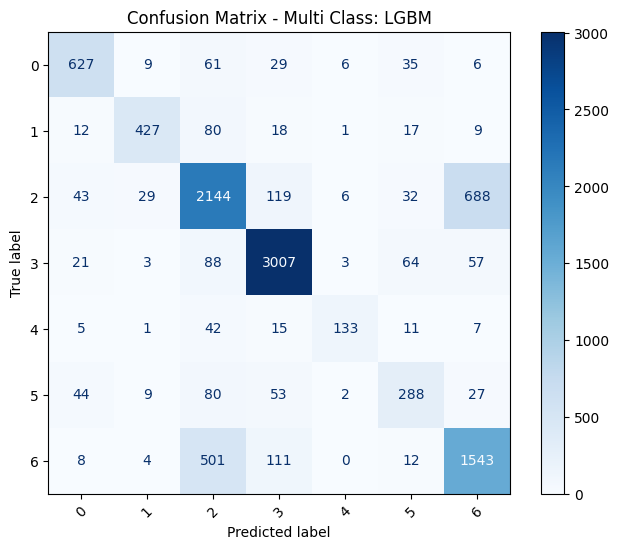

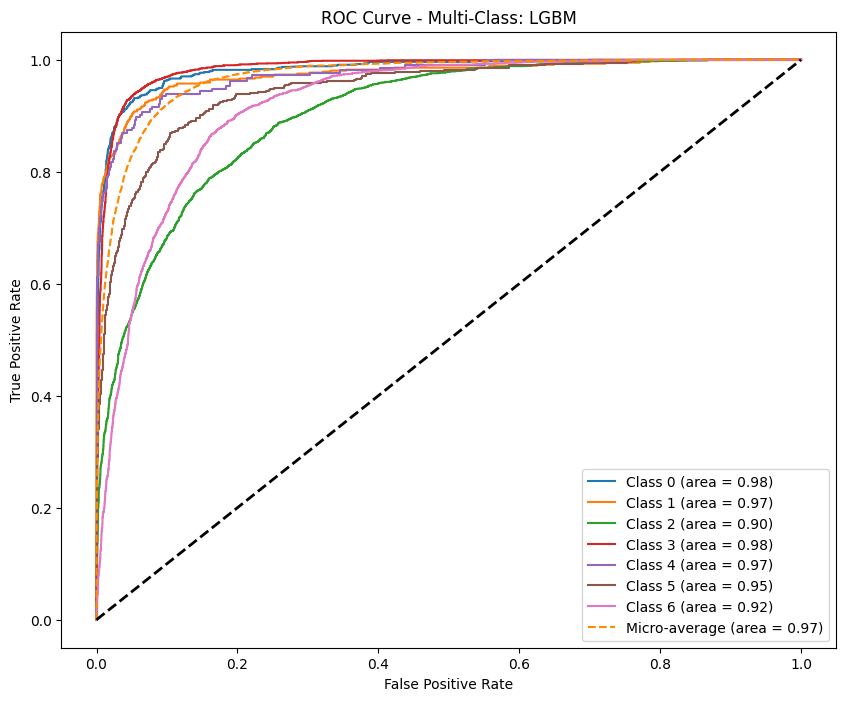

In [ ]:
#Plot confusion matrix and ROV curves
# Compute confusion matrix
cm = confusion_matrix(y_test_1, y_test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multi Class: LGBM")
plt.show()

n_classes = len(set(y_test_1))  # Number of classes
y_test_binarized = label_binarize(y_test_1, classes=list(range(n_classes)))

# Predict probabilities for each class
y_test_prob = best_model.predict_proba(X_test_1)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Individual ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:.2f})")

# Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (area = {roc_auc['micro']:.2f})", linestyle='--', color='darkorange')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curve - Multi-Class: LGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## 3.2  DL Models


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import Counter
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import numpy as np
import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 3.2.1 Albert

In [ ]:
#make a copy especially for ALBERT
df2 = df.copy()

In [ ]:
# Pre-processing for ALBERT
def clean_text_Albert(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs with <URL>
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions with <USER>
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags with <HASHTAG>
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df2['statement'] = df2['statement'].apply(clean_text_Albert)


In [ ]:
# Initial train-test split: 60% train, 20% test, 20% validation
train_texts_2, test_texts_2, train_labels_2, test_labels_2 = train_test_split(
    df2['statement'].tolist(), df2['encoded_status'].tolist(), test_size=0.2, random_state=42
)
train_texts_2, val_texts_2, train_labels_2, val_labels_2 = train_test_split(
    train_texts_2, train_labels_2, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)


#Prepare the data for the model
# Load tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
max_len = 200

# Create Dataset objects
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)  # Ensure texts is a list of strings
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure each text is a string
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset_2 = SentimentDataset(train_texts_2, train_labels_2, tokenizer,max_len)
test_dataset_2 = SentimentDataset(test_texts_2, test_labels_2, tokenizer,max_len)
val_dataset_2 = SentimentDataset(val_texts_2,val_labels_2,tokenizer,max_len)


# Create DataLoaders
train_loader_2 = DataLoader(train_dataset_2, batch_size=4, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2,batch_size = 4)
test_loader_2 = DataLoader(test_dataset_2, batch_size=4)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
random.seed(1234)

def random_hyperparameter_tuning(train_texts, train_labels, val_texts, val_labels, tokenizer, n_iter=10):
    # Define hyperparameter ranges
    param_space = {
        'lr': (np.log10(1e-5), np.log10(1e-4)),              # Learning rate range
        'epochs': (3, 5),                # Epoch range
        'dropout': (0.1, 0.5)           # Dropout rate range
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Compute class weights for class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Progress bar for random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True) as pbar:
        for _ in range(n_iter):
            # Randomly sample hyperparameters
            hyperparams = {
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
                'dropout': np.random.uniform(*param_space['dropout'])
            }

            # Initialize model with dropout
            model = AlbertForSequenceClassification.from_pretrained(
                'albert-base-v2',
                num_labels=7,
                hidden_dropout_prob=hyperparams['dropout']
            ).to(device)

            optimizer = AdamW(model.parameters(), lr=hyperparams['lr'])
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

            # Training loop
            for epoch in range(hyperparams['epochs']):
                model.train()
                for batch in train_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()

            # Validation evaluation
            model.eval()
            val_predictions, val_labels_batch = [], []
            with torch.no_grad():
                for batch in val_loader_2:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    preds = torch.argmax(outputs.logits, dim=1)
                    val_predictions.extend(preds.cpu().numpy())
                    val_labels_batch.extend(labels.cpu().numpy())

            # Calculate F1-score
            f1 = f1_score(val_labels_batch, val_predictions, average='weighted')
            accuracy = accuracy_score(val_labels_batch, val_predictions)

            # Update best model
            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model
                # Save the best model
                model_save_path = "best_albert_model.pth"
                torch.save(model.state_dict(), model_save_path)

            # Update progress bar
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

    print(f"Best F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
best_params, best_f1, best_model = random_hyperparameter_tuning(
    train_texts=train_texts_2,
    train_labels=train_labels_2,
    val_texts=val_texts_2,
    val_labels=val_labels_2,
    tokenizer=tokenizer,
    n_iter=10
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")

Random Search Tuning:   0%|          | 0/10 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Random Search Tuning:  10%|█         | 1/10 [39:24<5:54:42, 2364.74s/it, accuracy=0.312, f1=0.148]Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Random Search Tuning:  20%|██        | 2/10 [1:09:18<4:30:32, 2029.11s/it, accuracy=0.293, f1=0.133]Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model 

Best F1 Score: 0.7816
Best Hyperparameters: {'lr': 1.1668546806525978e-05, 'epochs': 4, 'dropout': 0.1532719106331748}
Total Parameter Tuning Time: 20860.15 seconds


In [ ]:
best_model.load_state_dict(torch.load("best_albert_model.pth"))
best_model.to(device)

# Initialize lists to store predictions and labels
test_predictions, test_labels_batch, test_probabilities = [], [], []

# Set the model to evaluation mode
best_model.eval()

# Perform evaluation
with torch.no_grad():
    for batch in test_loader_2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = best_model(input_ids, attention_mask=attention_mask)

        # Predicted labels
        preds = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

        # True labels
        test_labels_batch.extend(labels.cpu().numpy())

        # Probabilities for class 1
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        test_probabilities.extend(probs.cpu().numpy())

# Calculate F1 Score and Accuracy
test_f1 = f1_score(test_labels_batch, test_predictions, average='weighted')
test_accuracy = accuracy_score(test_labels_batch, test_predictions)

print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test F-1 Score: 0.7841, Test Accuracy: 0.7824


### 3.2.2 GRU

In [ ]:
#copy for GRU
df3 = df.copy()

In [ ]:
# Pre-processing for GRU - still minimal
def clean_text_GRU(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "<URL>", text)  # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)   # Replace mentions
    text = re.sub(r"#\w+", "<HASHTAG>", text)  # Replace hashtags
    text = re.sub(r"[^\w\s]", "", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)         # Normalize whitespace
    return text.strip()

df3['statement'] = df3['statement'].apply(clean_text_GRU)

In [ ]:
# Hyperparameters
MAX_LEN = 200  # Maximum sequence length
VOCAB_SIZE = 10000  # Vocabulary size
BATCH_SIZE = 16

# Split Dataset
# Initial train-test split
train_texts_3, test_texts_3, train_labels_3, test_labels_3 = train_test_split(
    df3['statement'].tolist(), df3['encoded_status'].tolist(), test_size=0.2, random_state=42
)
# Further split training data into training and validation sets
train_texts_3, val_texts_3, train_labels_3, val_labels_3 = train_test_split(
    train_texts_3, train_labels_3, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of original data
)

# **MODIFIED**: Build Vocabulary after the train-validation-test split
# Build Vocabulary on Training Data Only
all_train_words = " ".join(train_texts_3).split()
most_common_words = [word for word, _ in Counter(all_train_words).most_common(VOCAB_SIZE - 1)]
word_to_index = {word: idx + 1 for idx, word in enumerate(most_common_words)}

# Text-to-Sequence Conversion
def text_to_sequence(text, word_to_index, max_len=MAX_LEN):
    tokens = text.split()
    sequence = [word_to_index.get(word, 0) for word in tokens]
    return sequence[:max_len]

# Convert text to sequences for train, validation, and test sets
train_sequences_3 = [text_to_sequence(text, word_to_index) for text in train_texts_3]
val_sequences_3 = [text_to_sequence(text, word_to_index) for text in val_texts_3]
test_sequences_3 = [text_to_sequence(text, word_to_index) for text in test_texts_3]

# Pad Sequences
train_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in train_sequences_3], batch_first=True, padding_value=0)
val_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in val_sequences_3], batch_first=True, padding_value=0)
test_sequences_3 = nn.utils.rnn.pad_sequence([torch.tensor(seq) for seq in test_sequences_3], batch_first=True, padding_value=0)

# Convert Labels
train_labels_3 = torch.tensor(train_labels_3, dtype=torch.long)
val_labels_3 = torch.tensor(val_labels_3, dtype=torch.long)
test_labels_3 = torch.tensor(test_labels_3, dtype=torch.long)

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx],
            'label': self.labels[idx]
        }

# Create Datasets and DataLoaders
train_dataset_3 = SentimentDataset(train_sequences_3, train_labels_3)
val_dataset_3 = SentimentDataset(val_sequences_3, val_labels_3)
test_dataset_3 = SentimentDataset(test_sequences_3, test_labels_3)

train_loader_3 = DataLoader(train_dataset_3, batch_size=BATCH_SIZE, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(test_dataset_3, batch_size=BATCH_SIZE)

In [ ]:
# Define GRU Model
class GRUSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, hidden = self.gru(embedded)  # Only last hidden state
        output = self.fc(self.dropout(hidden[-1]))
        return output  # **MODIFIED**: Removed `softmax` because `CrossEntropyLoss` expects raw logits

# #Define Loss Function
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.2, gamma=0.5, ignore_index=-1):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.ignore_index = ignore_index
#         self.cross_entropy = nn.CrossEntropyLoss(ignore_index=ignore_index, reduction='none')

#     def forward(self, logits, target):
#         # Cross entropy loss
#         ce_loss = self.cross_entropy(logits, target)
#         # Probabilities of correct class
#         pt = torch.exp(-ce_loss)
#         # Focal loss
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()


In [ ]:
random.seed(1234)

def train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device):
    embedding_dim = int(hyperparams['embedding_dim'])
    hidden_dim = int(hyperparams['hidden_dim'])
    lr = hyperparams['lr']
    # alpha = hyperparams['alpha']
    # gamma = hyperparams['gamma']

    # Initialize the model, loss, and optimizer
    model = GRUSentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

    # **MODIFIED**: Compute class weights for the training set
    all_train_labels = [label for batch in train_loader for label in batch['label'].numpy()]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_train_labels),
        y=all_train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Convert to PyTorch tensor

    # **MODIFIED**: Use CrossEntropyLoss with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(hyperparams['epochs']):
        model.train()
        total_loss = 0
        train_loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{hyperparams['epochs']}", leave=True, position=0)
        for batch in train_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)  # **MODIFIED**: Use CrossEntropyLoss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            train_loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}/{hyperparams['epochs']}, Loss: {total_loss / len(train_loader):.4f}")

    # Validation evaluation
    model.eval()
    val_predictions, val_labels = [], []
    val_loop = tqdm(val_loader, desc="Validating", leave=True, position=0)
    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate F1 score and accuracy
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    accuracy = accuracy_score(val_labels, val_predictions)
    print(f"Validation F-1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return f1, accuracy, model


def random_hyperparameter_tuning(train_loader, val_loader, vocab_size, output_dim, device, n_iter=20):
    # Define hyperparameter ranges for random search
    param_space = {
        'embedding_dim': (150, 250),
        'hidden_dim': (256, 768),
        'lr': (np.log10(1e-4), np.log10(1e-3)),  # Log-uniform for learning rate
        'epochs': (5, 10),  # **MODIFIED**: Removed `alpha` and `gamma` since FocalLoss is no longer used
    }

    best_f1 = 0
    best_params = None
    best_model = None

    # Random search iterations
    with tqdm(total=n_iter, desc="Random Search Tuning", leave=True, position=0) as pbar:
        for _ in range(n_iter):
            # Sample hyperparameters
            hyperparams = {
                'embedding_dim': np.random.uniform(*param_space['embedding_dim']),
                'hidden_dim': np.random.uniform(*param_space['hidden_dim']),
                'lr': 10**np.random.uniform(*param_space['lr']),
                'epochs': np.random.randint(*param_space['epochs']),
            }
            f1, accuracy, model = train_and_evaluate(hyperparams, train_loader, val_loader, vocab_size, output_dim, device)
            pbar.set_postfix(f1=f1, accuracy=accuracy)
            pbar.update(1)

            if f1 > best_f1:
                best_f1 = f1
                best_params = hyperparams
                best_model = model

    print(f"Best Validation F1 Score: {best_f1:.4f}")
    print(f"Best Hyperparameters: {best_params}")

    # Save the best model
    torch.save(best_model.state_dict(), "best_gru_model.pth")
    return best_params, best_f1, best_model

#Start timer
start_time = time.time()
# Run random search
best_params, best_f1, best_model= random_hyperparameter_tuning(
    train_loader_3,
    val_loader_3,
    vocab_size=VOCAB_SIZE,
    output_dim=7,
    device=device,
    n_iter=10  # Number of random samples to evaluate
)
# End timer
end_time = time.time()
total_time = end_time - start_time
print(f"Total Parameter Tuning Time: {total_time:.2f} seconds")


Training Epoch 1/8: 100%|██████████| 1976/1976 [00:20<00:00, 94.67it/s, loss=0.791] 


Epoch 1/8, Loss: 1.6896


Training Epoch 2/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.97it/s, loss=1.25]


Epoch 2/8, Loss: 1.2287


Training Epoch 3/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.88it/s, loss=0.897]


Epoch 3/8, Loss: 0.9653


Training Epoch 4/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.57it/s, loss=2.4]


Epoch 4/8, Loss: 0.7063


Training Epoch 5/8: 100%|██████████| 1976/1976 [00:19<00:00, 103.56it/s, loss=1.02]


Epoch 5/8, Loss: 0.5615


Training Epoch 6/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.60it/s, loss=0.0708]


Epoch 6/8, Loss: 0.4555


Training Epoch 7/8: 100%|██████████| 1976/1976 [00:19<00:00, 103.09it/s, loss=0.445]


Epoch 7/8, Loss: 0.3733


Training Epoch 8/8: 100%|██████████| 1976/1976 [00:19<00:00, 102.79it/s, loss=0.475]


Epoch 8/8, Loss: 0.3059


Random Search Tuning:  10%|█         | 1/10 [02:38<23:44, 158.23s/it, accuracy=0.766, f1=0.77]

Validation F-1 Score: 0.7697, Accuracy: 0.7659


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:26<00:00, 74.07it/s, loss=1.22]


Epoch 1/6, Loss: 1.5322


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.90it/s, loss=0.959]


Epoch 2/6, Loss: 0.8890


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.93it/s, loss=0.897]


Epoch 3/6, Loss: 0.6092


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.83it/s, loss=0.129]


Epoch 4/6, Loss: 0.4394


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.93it/s, loss=0.18]


Epoch 5/6, Loss: 0.3118


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:26<00:00, 73.98it/s, loss=0.126]


Epoch 6/6, Loss: 0.2192


Random Search Tuning:  20%|██        | 2/10 [05:22<21:33, 161.74s/it, accuracy=0.776, f1=0.78]

Validation F-1 Score: 0.7796, Accuracy: 0.7759


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.37it/s, loss=1.54]


Epoch 1/7, Loss: 1.8098


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.67it/s, loss=0.859]


Epoch 2/7, Loss: 1.4336


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:18<00:00, 104.04it/s, loss=2.47]


Epoch 3/7, Loss: 1.2286


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.57it/s, loss=1.14]


Epoch 4/7, Loss: 1.1090


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.24it/s, loss=1.05]


Epoch 5/7, Loss: 0.9588


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.80it/s, loss=0.866]


Epoch 6/7, Loss: 0.8263


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:19<00:00, 103.62it/s, loss=1]


Epoch 7/7, Loss: 0.7041


Random Search Tuning:  30%|███       | 3/10 [07:38<17:30, 150.04s/it, accuracy=0.711, f1=0.715]

Validation F-1 Score: 0.7155, Accuracy: 0.7106


Training Epoch 1/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.03it/s, loss=2.74]


Epoch 1/7, Loss: 1.7805


Training Epoch 2/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.38it/s, loss=1.3]


Epoch 2/7, Loss: 1.4320


Training Epoch 3/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.37it/s, loss=1.51]


Epoch 3/7, Loss: 1.2367


Training Epoch 4/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.56it/s, loss=0.861]


Epoch 4/7, Loss: 1.1093


Training Epoch 5/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.62it/s, loss=0.471]


Epoch 5/7, Loss: 0.9145


Training Epoch 6/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.39it/s, loss=0.469]


Epoch 6/7, Loss: 0.7365


Training Epoch 7/7: 100%|██████████| 1976/1976 [00:21<00:00, 92.17it/s, loss=0.692]


Epoch 7/7, Loss: 0.6272


Random Search Tuning:  40%|████      | 4/10 [10:11<15:06, 151.13s/it, accuracy=0.726, f1=0.728]

Validation F-1 Score: 0.7282, Accuracy: 0.7262


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.40it/s, loss=0.849]


Epoch 1/9, Loss: 1.2165


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.45it/s, loss=1.08]


Epoch 2/9, Loss: 0.6593


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:21<00:00, 91.03it/s, loss=0.41]


Epoch 3/9, Loss: 0.4325


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.77it/s, loss=0.174]


Epoch 4/9, Loss: 0.2936


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.91it/s, loss=0.268]


Epoch 5/9, Loss: 0.2096


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.75it/s, loss=0.179]


Epoch 6/9, Loss: 0.1627


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.38it/s, loss=0.074]


Epoch 7/9, Loss: 0.1447


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.50it/s, loss=0.173]


Epoch 8/9, Loss: 0.1305


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:21<00:00, 90.40it/s, loss=0.0904]


Epoch 9/9, Loss: 0.1132


Random Search Tuning:  50%|█████     | 5/10 [13:30<14:02, 168.50s/it, accuracy=0.764, f1=0.766]

Validation F-1 Score: 0.7663, Accuracy: 0.7641


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.02it/s, loss=1.6]


Epoch 1/6, Loss: 1.4366


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:18<00:00, 109.02it/s, loss=0.551]


Epoch 2/6, Loss: 0.7683


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.63it/s, loss=0.266]


Epoch 3/6, Loss: 0.5327


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.24it/s, loss=0.207]


Epoch 4/6, Loss: 0.3669


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:18<00:00, 108.86it/s, loss=0.148]


Epoch 5/6, Loss: 0.2623


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:18<00:00, 109.07it/s, loss=0.043]


Epoch 6/6, Loss: 0.1968


Random Search Tuning:  60%|██████    | 6/10 [15:22<09:56, 149.09s/it, accuracy=0.76, f1=0.764]

Validation F-1 Score: 0.7642, Accuracy: 0.7600


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:20<00:00, 94.40it/s, loss=0.233]


Epoch 1/9, Loss: 1.2384


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:20<00:00, 94.69it/s, loss=1.1]


Epoch 2/9, Loss: 0.6694


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.16it/s, loss=2.22]


Epoch 3/9, Loss: 0.4330


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.20it/s, loss=0.196]


Epoch 4/9, Loss: 0.2824


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.46it/s, loss=0.149]


Epoch 5/9, Loss: 0.2170


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.18it/s, loss=0.285]


Epoch 6/9, Loss: 0.1659


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.13it/s, loss=0.545]


Epoch 7/9, Loss: 0.1418


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.70it/s, loss=0.0806]


Epoch 8/9, Loss: 0.1046


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:20<00:00, 95.36it/s, loss=0.0031]


Epoch 9/9, Loss: 0.1074


Random Search Tuning:  70%|███████   | 7/10 [18:31<08:07, 162.41s/it, accuracy=0.772, f1=0.77]

Validation F-1 Score: 0.7695, Accuracy: 0.7717


Training Epoch 1/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.25it/s, loss=0.855]


Epoch 1/8, Loss: 1.5821


Training Epoch 2/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.43it/s, loss=0.819] 


Epoch 2/8, Loss: 1.0667


Training Epoch 3/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.39it/s, loss=0.451]


Epoch 3/8, Loss: 0.7212


Training Epoch 4/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.06it/s, loss=1.21]


Epoch 4/8, Loss: 0.5464


Training Epoch 5/8: 100%|██████████| 1976/1976 [00:19<00:00, 99.77it/s, loss=0.339]


Epoch 5/8, Loss: 0.4140


Training Epoch 6/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.33it/s, loss=0.217]


Epoch 6/8, Loss: 0.3052


Training Epoch 7/8: 100%|██████████| 1976/1976 [00:19<00:00, 100.09it/s, loss=0.788]


Epoch 7/8, Loss: 0.2486


Training Epoch 8/8: 100%|██████████| 1976/1976 [00:20<00:00, 97.84it/s, loss=0.487]


Epoch 8/8, Loss: 0.2028


Random Search Tuning:  80%|████████  | 8/10 [21:13<05:24, 162.24s/it, accuracy=0.777, f1=0.778]

Validation F-1 Score: 0.7782, Accuracy: 0.7769


Training Epoch 1/6: 100%|██████████| 1976/1976 [00:19<00:00, 99.94it/s, loss=1.65] 


Epoch 1/6, Loss: 1.6916


Training Epoch 2/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.26it/s, loss=0.964]


Epoch 2/6, Loss: 1.2137


Training Epoch 3/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.19it/s, loss=0.696]


Epoch 3/6, Loss: 0.8946


Training Epoch 4/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.44it/s, loss=0.225]


Epoch 4/6, Loss: 0.6601


Training Epoch 5/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.45it/s, loss=0.189]


Epoch 5/6, Loss: 0.5230


Training Epoch 6/6: 100%|██████████| 1976/1976 [00:19<00:00, 100.47it/s, loss=0.182]


Epoch 6/6, Loss: 0.4109


Random Search Tuning:  90%|█████████ | 9/10 [23:14<02:29, 149.31s/it, accuracy=0.754, f1=0.758]

Validation F-1 Score: 0.7579, Accuracy: 0.7539


Training Epoch 1/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.44it/s, loss=1.05]


Epoch 1/9, Loss: 1.2652


Training Epoch 2/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.40it/s, loss=0.422]


Epoch 2/9, Loss: 0.6715


Training Epoch 3/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.44it/s, loss=0.592]


Epoch 3/9, Loss: 0.4501


Training Epoch 4/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.45it/s, loss=0.601]


Epoch 4/9, Loss: 0.3020


Training Epoch 5/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.80it/s, loss=0.117]


Epoch 5/9, Loss: 0.2201


Training Epoch 6/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.51it/s, loss=0.207]


Epoch 6/9, Loss: 0.1883


Training Epoch 7/9: 100%|██████████| 1976/1976 [00:18<00:00, 105.23it/s, loss=0.0495]


Epoch 7/9, Loss: 0.1551


Training Epoch 8/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.09it/s, loss=0.154]


Epoch 8/9, Loss: 0.1269


Training Epoch 9/9: 100%|██████████| 1976/1976 [00:18<00:00, 104.22it/s, loss=0.03]


Epoch 9/9, Loss: 0.1186


Random Search Tuning: 100%|██████████| 10/10 [26:07<00:00, 156.72s/it, accuracy=0.766, f1=0.768]

Validation F-1 Score: 0.7676, Accuracy: 0.7661
Best Validation F1 Score: 0.7796
Best Hyperparameters: {'embedding_dim': 236.21551351942213, 'hidden_dim': 730.8954918537037, 'lr': 0.0002984445605274827, 'epochs': 6}
Total Parameter Tuning Time: 1567.24 seconds


In [ ]:
# Evaluate the best model on the test set
best_model.eval()
test_predictions, test_labels = [], []
test_probabilities = []
# **MODIFIED**: Added probabilities collection for further analysis if needed

with torch.no_grad():
    for batch in test_loader_3:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = best_model(input_ids)

        # Apply softmax to get probabilities for all classes
        probs = torch.softmax(outputs, dim=1)
        test_probabilities.extend(probs.cpu().numpy())  # Collect probabilities for all classes

        # Collect predictions and labels (unchanged)
        preds = torch.argmax(probs, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate F1 score and accuracy on the test set
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Test F-1 Score: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, digits=4))

Test F-1 Score: 0.7756, Test Accuracy: 0.7720

Classification Report:
              precision    recall  f1-score   support

           0     0.8011    0.7710    0.7858       773
           1     0.8297    0.7429    0.7839       564
           2     0.7488    0.7030    0.7252      3061
           3     0.9345    0.9016    0.9178      3243
           4     0.4703    0.7757    0.5855       214
           5     0.5102    0.7435    0.6052       503
           6     0.6839    0.6902    0.6871      2179

    accuracy                         0.7720     10537
   macro avg     0.7112    0.7612    0.7272     10537
weighted avg     0.7837    0.7720    0.7756     10537



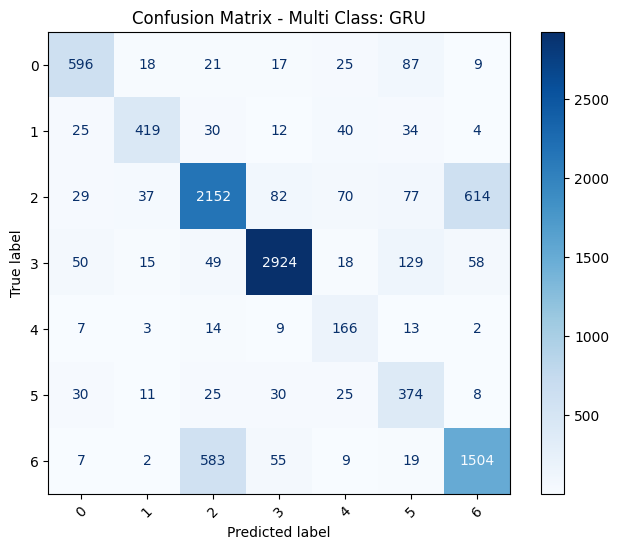

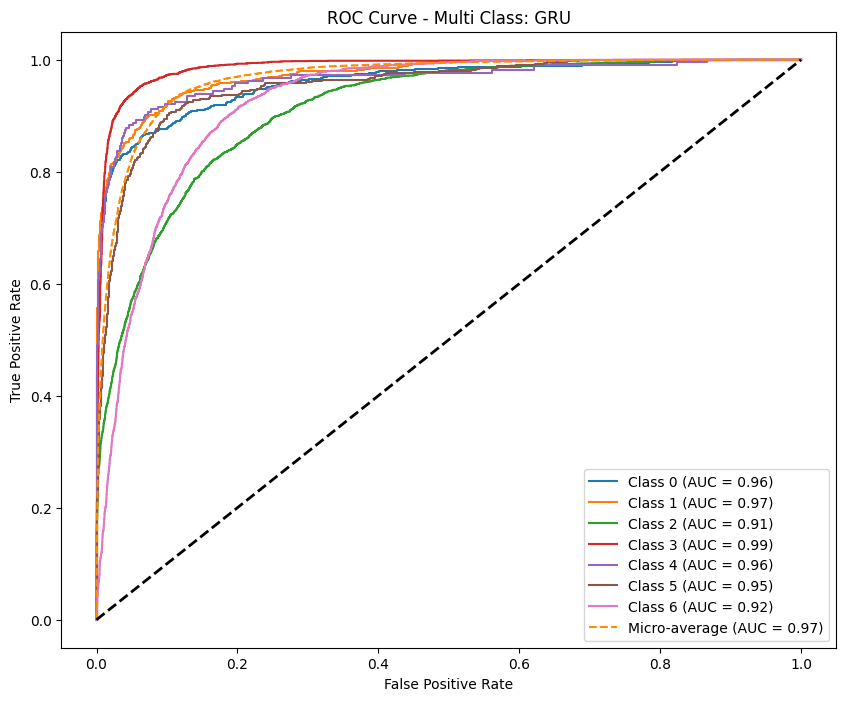

In [ ]:
#Plot confusion matrix and ROV curves
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(outputs.shape[1]))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Multi Class: GRU")
plt.show()

n_classes = len(set(test_labels))  # Number of classes
test_labels_binarized = label_binarize(test_labels, classes=range(n_classes))

# Step 2: Convert test_probabilities to a matrix
# Since test_probabilities contains probabilities for a single class, expand it for all classes
test_probabilities = np.array(test_probabilities)  # If not already an array

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), test_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Individual ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='darkorange')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels, title, and legend
plt.title("ROC Curve - Multi Class: GRU")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()